**This notebook is an exercise in the [AI Ethics](https://www.kaggle.com/learn/ai-ethics) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/ai-fairness).**

---


In the tutorial, you learned about different ways of measuring fairness of a machine learning model.  In this exercise, you'll train a few models to approve (or deny) credit card applications and analyze fairness.  Don't worry if you're new to coding: this exercise assumes no programming knowledge.

# Introduction

We work with a **synthetic** dataset of information submitted by credit card applicants. 

To load and preview the data, run the next code cell.  When the code finishes running, you should see a message saying the data was successfully loaded, along with a preview of the first five rows of the data.

In [1]:
# Set up feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.ethics.ex4 import *
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data, separate features from target
data = pd.read_csv("../input/synthetic-credit-card-approval/synthetic_credit_card_approval.csv")
X = data.drop(["Target"], axis=1)
y = data["Target"]

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Preview the data
print("Data successfully loaded!\n")
X_train.head()

Data successfully loaded!



,Num_Children,Group,Income,Own_Car,Own_Housing
288363,1,1,40690,0,1
64982,2,0,75469,1,0
227641,1,1,70497,1,1
137672,1,1,61000,0,0
12758,1,1,56666,1,1


 The dataset contains, for each applicant:
- income (in the `Income` column),
- the number of children (in the `Num_Children` column),
- whether the applicant owns a car (in the `Own_Car` column, the value is `1` if the applicant owns a car, and is else `0`), and
- whether the applicant owns a home (in the `Own_Housing` column, the value is `1` if the applicant owns a home, and is else `0`)

When evaluating fairness, we'll check how the model performs for users in different groups, as identified by the `Group` column: 
- The `Group` column breaks the users into two groups (where each group corresponds to either `0` or `1`).  
- For instance, you can think of the column as breaking the users into two different races, ethnicities, or gender groupings.  If the column breaks users into different ethnicities, `0` could correspond to a non-Hispanic user, while `1` corresponds to a Hispanic user. 


Run the next code cell without changes to train a simple model to approve or deny individuals for a credit card.  The output shows the performance of the model.

Total approvals: 38246
Group A: 8028 (20.99% of approvals)
Group B: 30218 (79.01% of approvals)

Overall accuracy: 94.79%
Group A: 94.56%
Group B: 95.02%

Sensitivity / True positive rate:
Group A: 77.23%
Group B: 98.03%


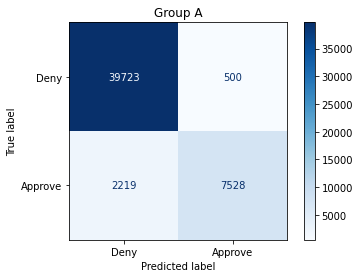

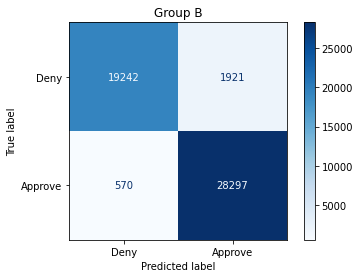

In [2]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train a model and make predictions
model_baseline = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)
preds_baseline = model_baseline.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

# Function to evaluate the fairness of the model
def get_stats(X, y, model, group_one, preds):
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    print("Total approvals:", preds.sum())
    print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group A: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group B: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))
    
    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group A")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group B")
    
    print("\nSensitivity / True positive rate:")
    print("Group A: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group B: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))
    
# Evaluate the model    
get_stats(X_test, y_test, model_baseline, X_test["Group"]==1, preds_baseline)

The confusion matrices above show how the model performs on some test data. We also print additional information (calculated from the confusion matrices) to assess fairness of the model. For instance,
- The model approved 38246 people for a credit card. Of these individuals, 8028 belonged to Group A, and 30218 belonged to Group B.
- The model is 94.56% accurate for Group A, and 95.02% accurate for Group B. These percentages can be calculated directly from the confusion matrix; for instance, for Group A, the accuracy is (39723+7528)/(39723+500+2219+7528).
- The true positive rate (TPR) for Group A is 77.23%, and the TPR for Group B is 98.03%. These percentages can be calculated directly from the confusion matrix; for instance, for Group A, the TPR is 7528/(7528+2219).

# 1) Varieties of fairness

Consider three different types of fairness covered in the tutorial:
- **Demographic parity**: Which group has an unfair advantage, with more representation in the group of approved applicants?  (Roughly 50% of applicants are from Group A, and 50% of applicants are from Group B.)
- **Equal accuracy**: Which group has an unfair advantage, where applicants are more likely to be correctly classified? 
- **Equal opportunity**:  Which group has an unfair advantage, with a higher true positive rate?

In [3]:
# Check your answer (Run this code cell to get credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Solution:</span> All of the fairness criteria are unfairly biased in favor of Group B. 79.01% of applicants are from Group B -- if demographic parity is our fairness criterion, fair would mean that 50% of the applicants are from Group B. The model is also slightly more accurate for applicants from Group B (with accuracy of 95.02%, vs 94.56% for Group A). The true positive rate is very high for Group B (98.03%, vs. 77.23% for Group A). In other words, for Group B, almost all people who should be approved are actually approved. For Group A, if you should be approved, your chances of actually being approved are much lower.

Run the next code cell without changes to visualize the model.

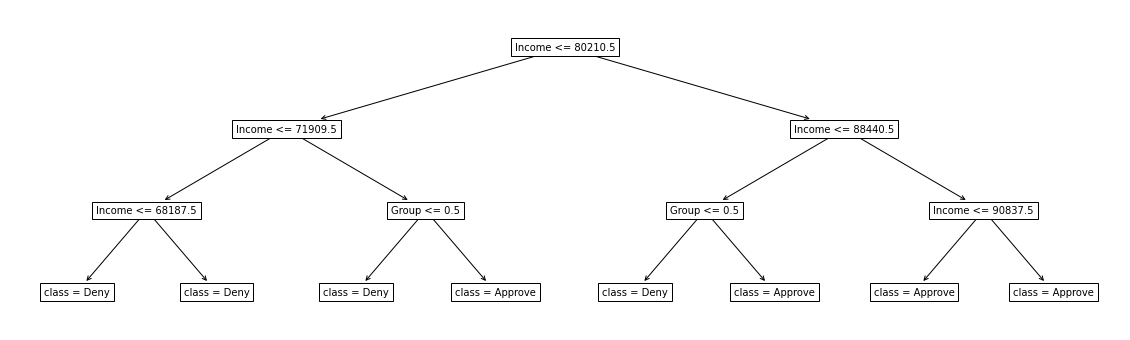

In [4]:
def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False):
    plot_list = tree.plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
    [process_plot_item(item) for item in plot_list]

def process_plot_item(item):
    split_string = item.get_text().split("\n")
    if split_string[0].startswith("samples"):
        item.set_text(split_string[-1])
    else:
        item.set_text(split_string[0])

plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_baseline, feature_names=X_train.columns)

The flowchart shows how the model makes decisions:
- `Group <= 0.5` checks what group the applicant belongs to: if the applicant belongs to Group A, then `Group <= 0.5` is true.
- Entries like `Income <= 80210.5` check the applicant's income.

To follow the flow chart, we start at the top and trace a path depending on the details of the applicant.  If the condition is true at a split, then we move down and to the left branch.  If it is false, then we move to the right branch.

For instance, consider an applicant in Group B, who has an income of 75k.  Then, 
- We start at the top of the flow chart.  the applicant has an income of 75k, so `Income <= 80210.5` is true, and we move to the left.
- Next, we check the income again. Since `Income <= 71909.5` is false, we move to the right.
- The last thing to check is what group the applicant belongs to.  The applicant belongs to Group B, so `Group <= 0.5` is false, and we move to the right, where the model has decided to approve the applicant.

# 2) Understand the baseline model

Based on the visualization, how can you explain one source of unfairness in the model?

**Hint**: Consider the example applicant, but change the group membership from Group B to Group A (leaving all other characteristics the same).  Is this slightly different applicant approved or denied by the model?

In [5]:
# Check your answer (Run this code cell to get credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Solution:</span> For all applicants with income between 71909.5 and 88440.5, the model's decision depends on group membership: the model approves applicants from Group B and denies applicants from Group A.  Since we want the model to treat individuals from Group A and Group B fairly, this is clearly a bad model.  Although this data is very simple, in practice, with much larger data, visualizing the how a model makes decisions can be very useful to more deeply understand what might be going wrong with a model.

Next, you decide to remove group membership from the training data and train a new model.  Do you think this will make the model treat the groups more equally?

Run the next code cell to see how this new **group unaware** model performs.

Total approvals: 36670
Group A: 11624 (31.7% of approvals)
Group B: 25046 (68.3% of approvals)

Overall accuracy: 92.66%
Group A: 93.61%
Group B: 91.72%

Sensitivity / True positive rate:
Group A: 93.24%
Group B: 86.21%


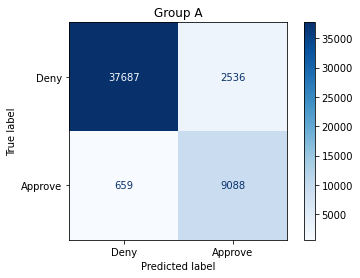

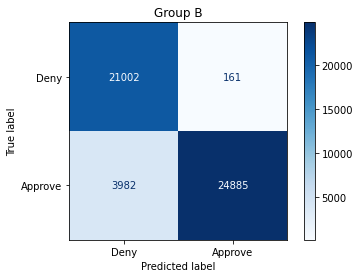

In [6]:
# Create new dataset with gender removed
X_train_unaware = X_train.drop(["Group"],axis=1)
X_test_unaware = X_test.drop(["Group"],axis=1)

# Train new model on new dataset
model_unaware = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_unaware.fit(X_train_unaware, y_train)

# Evaluate the model
preds_unaware = model_unaware.predict(X_test_unaware)
get_stats(X_test_unaware, y_test, model_unaware, X_test["Group"]==1, preds_unaware)

# 3) Varieties of fairness, part 2

How does this model compare to the first model you trained, when you consider **demographic parity**, **equal accuracy**, and **equal opportunity**?  Once you have an answer, run the next code cell.

In [7]:
# Check your answer (Run this code cell to get credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Solution:</span> When we consider demographic parity, the new model is still biased in favor of Group B, but is now a bit more fair than the original model. But now, if you consider either equal accuracy or equal opportunity, the model is biased in favor of Group A! It's also important to note that the overall accuracy of the model has dropped -- for each group, the model is making slightly less accurate decisions.

You decide to train a third potential model, this time with the goal of having each group have even representation in the group of approved applicants.  (This is an implementation of group thresholds, which you can optionally read more about [here](https://pair-code.github.io/what-if-tool/ai-fairness.html).)  

Run the next code cell without changes to evaluate this new model.  

Total approvals: 38241
Group A: 19869 (51.96% of approvals)
Group B: 18372 (48.04% of approvals)

Overall accuracy: 79.38%
Group A: 79.74%
Group B: 79.02%

Sensitivity / True positive rate:
Group A: 100.0%
Group B: 63.64%


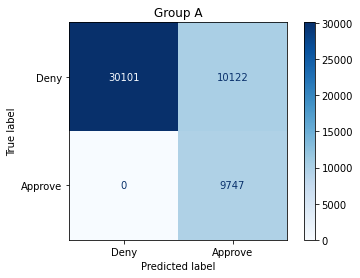

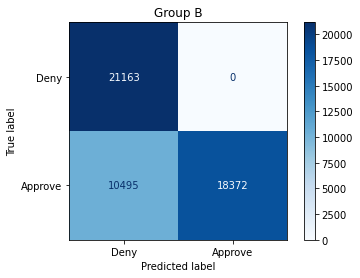

In [8]:
# Change the value of zero_threshold to hit the objective
zero_threshold = 0.11
one_threshold = 0.99

# Evaluate the model
test_probs = model_unaware.predict_proba(X_test_unaware)[:,1]
preds_approval = (((test_probs>zero_threshold)*1)*[X_test["Group"]==0] + ((test_probs>one_threshold)*1)*[X_test["Group"]==1])[0]
get_stats(X_test, y_test, model_unaware, X_test["Group"]==1, preds_approval)

# 4) Varieties of fairness, part 3

How does this final model compare to the previous models, when you consider **demographic parity**, **equal accuracy**, and **equal opportunity**?

In [9]:
# Check your answer (Run this code cell to get credit!)
q_4.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Solution:</span> This model acheives nearly equal representation in the pool of approved applicants from each group -- if demographic parity is what we care about, then this model is much more fair than the first two models. Accuracy is roughly the same for each group, but there is a substantial drop in overall accuracy for each group. If we examine the model for equal opportunity fairness, the model is biased in favor of Group A: all individuals from Group A who should be approved are approved, whereas only 63% of individuals from Group B who should be approved are approved.  (This is similar to the dynamic in the first model, with the favored group switched -- that is, in the first model, nearly all individuals from Group B who should be approved were approved by the model.

This is only a short exercise to explore different types of fairness, and to illustrate the tradeoff that can occur when you optimize for one type of fairness over another.  We have focused on model training here, but in practice, to really mitigate bias, or to make ML systems fair, we need to take a close look at every step in the process, from data collection to releasing a final product to users. 

For instance, if you take a close look at the data, you'll notice that on average, individuals from Group B tend to have higher income than individuals from Group A, and are also more likely to own a home or a car.  Knowing this will prove invaluable to deciding what fairness criterion you should use, and to inform ways to achieve fairness.  (*For instance, it would likely be a bad aproach, if you did not remove the historical bias in the data and then train the model to get equal accuracy for each group.*)

In this course, we intentionally avoid taking an opinionated stance on how exactly to minimize bias and ensure fairness in specific projects.  This is because the correct answers continue to evolve, since AI fairness is an active area of research.  This lesson was a hands-on introduction to the topic, and you can continue your learning by reading blog posts from the [Partnership on AI](https://www.partnershiponai.org/research-lander/) or by following conferences like the [ACM Conference on Fairness, Accountability, and Transparency (ACM FAccT)](https://facctconference.org/).

# Keep going

Continue to **[learn how to use model cards](https://www.kaggle.com/var0101/model-cards)** to make machine learning models transparent to large audiences.